# CMSE 202 Final Project - Dream Classification
### Names: Emma Fountain, Holly Sederlund, Samantha Tadian, Myles Yankie


## Abstract
The basic premise of our project was trying to predict dreams using fMRI and EEG data from various areas of the brain. Using the data of the brain waves from those tests, we tried predicting the dreams using key words as our classes. We found that the Support Vector Model (SVM) was the best machine-learning technique for doing this, and that because there was the most data for the key word "male" and "character", we found that those two classes were the best for predicting dreams based on brain waves. 

Below, our story tells of how we loaded in an unfamiliar dataset and synthesizing machine learning models to make predictions. We took a trial-and-error approach by first trying a Logistic Regression Model then by doing an SVM, and we ultimately found that SVM worked best in predicting dreams.

# Initial Data Exploration
This is going to be a little difficult for a couple of reasons

1. The data is poorly described, there is not accompanying readme or documentation on what each of the fields means. We are going to have to rely on the [original paper](https://www.researchgate.net/profile/Masako-Tamaki/publication/236113471_Neural_Decoding_of_Visual_Imagery_During_Sleep/links/02e7e53a5e1eba1005000000/Neural-Decoding-of-Visual-Imagery-During-Sleep.pdf) and its [supplemental materials](https://www.science.org/doi/suppl/10.1126/science.1234330/suppl_file/horikawa.sm.pdf) to figure out how to use it
2. The data is in an h5 format, which is something we haven't worked with before
3. The data is spread across several files, so we will have to aggregate it ourselves

In [4]:
!ls preproc

PreprocessedPerceptionDataSubject1.h5  PreprocessedSleepDataSubject3.h5
PreprocessedPerceptionDataSubject2.h5  propsSubject1.h5
PreprocessedPerceptionDataSubject3.h5  propsSubject2.h5
PreprocessedSleepDataSubject1.h5       propsSubject3.h5
PreprocessedSleepDataSubject2.h5


The files appear to be in "h5" format, which we can read using the h5py library ([documentation](https://docs.h5py.org/en/stable/))

It seems like there's 3 different classes of files, Perception data, Sleep data, and "props"?

The paper attempts to reconstruct visual data rather than just classify, so it uses a decoder trained from perception data while viewing particular images, most likely the "Perception" data, so we can probably ignore this. 

The sleep data probably has what we are looking for.

I'm not really sure what props is.

In [5]:
import h5py
import os

In [6]:
root = "preproc"
perc = os.path.join(root, "PreprocessedPerceptionDataSubject1.h5")
sleep = os.path.join(root, "PreprocessedSleepDataSubject1.h5")
props = os.path.join(root, "propsSubject1.h5")

Start with sleep data

In [7]:
dfile = h5py.File(sleep, "r")
dfile.keys()

<KeysViewHDF5 ['data', 'metaData', 'metaDefinition']>

Looks like theres 3 keys in the dataset, data, metadata, and metadefinition

In [8]:
for key in dfile.keys():
    dset = dfile[key]
    try:
        print(key, dset.shape, dset.dtype, dset[0], end="\n\n")
    except:
        print(key, dset, type(key), end="\n\n")

data (235, 4039) float64 [-1.23439404 -0.48702744  1.19918902 ...  1.          1.
  1.        ]

metaData <HDF5 group "/metaData" (43 members)> <class 'str'>

metaDefinition (43,) |S33 b'0 = not voxelData, 1 = voxelData'



In [9]:
tfile = h5py.File(os.path.join(root, "PreprocessedSleepDataSubject2.h5"), "r")
tfile["data"].shape

(198, 3981)

Looks like data is just a 2D array of data with where the first dimension is the number of "awakenings", which is confirmed by the paper...
> (235, 198, and
186 awakenings for participants 1 to 3, respec-
tively, used for decoding analyses) 

metaData is a group and metaDefinition contains some kind of string data, the "meta" datasets seem to be related since they have the same number of elements

In [10]:
data = dfile["data"]
mdata = dfile["metaData"]
mdef = dfile["metaDefinition"]
for i, key in enumerate(mdata):
    print(i, key, mdata[key].shape, " -- ",mdef[i])

0 EEG_sleep_score (1, 4039)  --  b'0 = not voxelData, 1 = voxelData'
1 FFA (1, 4039)  --  b'Value = X coordinate'
2 HVC (1, 4039)  --  b'Value = Y coordinate'
3 LOC (1, 4039)  --  b'Value = Z coordinate'
4 LVC (1, 4039)  --  b'0 = not FFA voxel, 1 = FFA voxel'
5 PPA (1, 4039)  --  b'0 = not HVC voxel, 1 = HVC voxel'
6 Synset_building_ID_02913152 (1, 4039)  --  b'0 = not LOC voxel, 1 = LOC voxel'
7 Synset_chair_ID_03001627 (1, 4039)  --  b'0 = not LVC voxel, 1 = LVC voxel'
8 Synset_character_ID_06818970 (1, 4039)  --  b'0 = not PPA voxel, 1 = PPA voxel'
9 Synset_clothing_ID_03051540 (1, 4039)  --  b'0 = not V1 voxel, 1 = V1 voxel'
10 Synset_code_ID_06355894 (1, 4039)  --  b'0 = not V2 voxel, 1 = V2 voxel'
11 Synset_cognition_ID_00023271 (1, 4039)  --  b'0 = not V3 voxel, 1 = V3 voxel'
12 Synset_external_body_part_ID_05225090 (1, 4039)  --  b'0 = not label, 1 = label'
13 Synset_geographical_area_ID_08574314 (1, 4039)  --  b'0 = absent, 1 = present'
14 Synset_girl_ID_10129825 (1, 4039)  -

Seem to be feature-value pairs, mapped to the data using masks?

Also, these seem to be out of order, most likely since dictionary indexing is unordered, but that shouldn't really be a problem since we have masks describing their regions

From the paper we know...
- LVC, HVC, V1, V2, V3, LOC, FF, and PPA are all visual areas. These will be our input
- Synsets are the different "classes" of things they saw in their dreams, these will be what we are trying to predict.

It looks like this is all we need, but I'm still going to take a look at "props" just to see what it is.

In [11]:
pfile = h5py.File(props, "r")
pfile.keys()

<KeysViewHDF5 ['roiMask', 'roiNames', 'synsetNames', 'synsetPairs', 'xyz']>

In [12]:
for key in pfile.keys():
    dset = pfile[key]
    try:
        print(key, dset.shape, dset.dtype, dset[0], end="\n\n")
    except:
        print(key, dset, type(key), end="\n\n")

roiMask (8, 4010) float64 [0. 0. 0. ... 0. 0. 0.]

roiNames (8,) |S4 b'FFA'

synsetNames (26,) |S38 b'Synset_male_ID_09624168'

synsetPairs (201, 2) |S38 [b'Synset_character_ID_06818970' b'Synset_male_ID_09624168']

xyz (3, 4010) float64 [-67.5 -67.5 -67.5 ...  64.5  64.5  64.5]



This seems to be the information on the boundaries between each of the features described in the "sleep" data. From the supplemental materials, the roi is "region of interest" which is the region of the brain.

In [13]:
rmask = pfile["roiMask"]
rnames = pfile["roiNames"]
xyz = pfile["xyz"]

print(rmask[0, :].sum(), rnames[0])
print(xyz[:, 2])

for region in range(len(rnames)):
    numel = rmask[region].sum() # number of "1" elements in the roi masks
    numel_d = sum(mdata[rnames[region]][0]) # number of "1" elements in corresponding mdata masks
    print(rnames[region], " -- ", numel, " -- ", numel_d) # should both be the same

537.0 b'FFA'
[-67.5 -43.5  -4.5]
b'FFA'  --  537.0  --  537.0
b'HVC'  --  1956.0  --  1956.0
b'LOC'  --  523.0  --  523.0
b'LVC'  --  2054.0  --  2054.0
b'PPA'  --  353.0  --  353.0
b'V1'  --  885.0  --  885.0
b'V2'  --  901.0  --  901.0
b'V3'  --  728.0  --  728.0


From the supplemental materials...
> For the analysis of individual subareas, the following numbers of voxels were identified
for V1, V2, V3, LOC, FFA, and PPA, respectively: 885, 901, 728, 523, 537, and 353 voxels for Subject 1;

This matches with the sum of our region of interest masks, meaning that these masks do in fact show the region of interest. The "xyz" feature appears to be the voxel (3d pixel) coordinates corresponding to each entry in our region of interest (which we don't really need)

In [14]:
print(data.shape)
ffa_mask = rmask[0].astype(bool)
print(ffa_mask.shape)

(235, 4039)
(4010,)


The mask seems to be shorter by 29 elements, which I would assume is the space for the meta elements?

In [15]:
data[-1, 4009:]

array([  1.97166996,   1.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   1.        ,
        26.        , 235.        ])

Yep! The last two seem to be numbers rather than logical values which matches what we would expect if `mdef` is properly ordered. Now we just need to extract all of the info into a more user-friendly form, probably pandas.

# Structure Data

In [16]:
import numpy as np
import pandas as pd

Pandas `read_hf` function apparently has problems, and I can't get it to read properly so I'm just going to create the dataframes manually

We can't really mask the data right now to extract features since we would end up with a ragged dataframe (different lengths for each column) which pandas doesn't like. Instead, I'll just make a dataframe of the masks and make the data into a numpy array.

In [17]:
dfile = h5py.File(sleep, "r") #data file

data = dfile["data"]
mdata = dfile["metaData"]

#convert from h5 to a dictionary of np arrays, which pandas understands
mdata_dict_arr = {key: np.squeeze(np.array(val)) for key, val in mdata.items()}

meta_df = pd.DataFrame.from_dict(mdata_dict_arr)
data_df = np.array(data)

In [18]:
print(meta_df.shape)
meta_df.head()

(4039, 43)


,EEG_sleep_score,FFA,HVC,LOC,LVC,PPA,Synset_building_ID_02913152,Synset_chair_ID_03001627,Synset_character_ID_06818970,Synset_clothing_ID_03051540,...,V2,V3,X,Y,Z,design,label,sample_number,session_number,voxelData
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-67.5,-46.5,-1.5,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-67.5,-46.5,1.5,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-67.5,-43.5,-4.5,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-67.5,-43.5,-1.5,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-64.5,-52.5,-4.5,0.0,0.0,0.0,0.0,1.0


In [19]:
print(data_df.shape)

(235, 4039)


In [20]:
data_df

array([[-1.23439404e+00, -4.87027437e-01,  1.19918902e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.63373625e+00,  5.24539088e+00, -1.69498203e+00, ...,
         1.00000000e+00,  1.00000000e+00,  2.00000000e+00],
       [ 4.01640746e-01,  3.25192376e+00, -1.38049469e+00, ...,
         1.00000000e+00,  1.00000000e+00,  3.00000000e+00],
       ...,
       [-2.85550630e+00, -2.69055550e+00, -1.17711014e+00, ...,
         1.00000000e+00,  2.60000000e+01,  2.33000000e+02],
       [-1.89436357e-01, -1.59084747e+00,  2.13385080e+00, ...,
         1.00000000e+00,  2.60000000e+01,  2.34000000e+02],
       [-1.89219074e+00, -2.45376516e+00,  3.57550935e+00, ...,
         1.00000000e+00,  2.60000000e+01,  2.35000000e+02]])

Now that we're done with exploration, I'll add a module `utils` with the function `load_data` into the main project folder so that we can get these structures more easily. I added full docstrings, so it should be pretty easy to use, just take a look in the file for info on inputs and outputs.

In [21]:
import utils

masks, data =  utils.load_data(1)

In [22]:
masks.head()

,EEG_sleep_score,FFA,HVC,LOC,LVC,PPA,Synset_building_ID_02913152,Synset_chair_ID_03001627,Synset_character_ID_06818970,Synset_clothing_ID_03051540,...,V2,V3,X,Y,Z,design,label,sample_number,session_number,voxelData
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-67.5,-46.5,-1.5,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-67.5,-46.5,1.5,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-67.5,-43.5,-4.5,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-67.5,-43.5,-1.5,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-64.5,-52.5,-4.5,0.0,0.0,0.0,0.0,1.0


In [23]:
print(f"data shape: {data.shape}")

data shape: (235, 4039)


Below are a number of functions and a class to handle data preprocessing

In [45]:
import pandas as pd
import numpy as np
import h5py
import os

from sklearn.model_selection import train_test_split

def get_subject_path(subject):
    """
    Convenience function to get the filename for a particular
    subject

    Parameters:
        subject: An int (1-3) corresponding to the subject number
    
    Returns:
        The filename for the sleep data for the subject

    """

    return "".join(["PreprocessedSleepDataSubject", str(subject), ".h5"])

def cvt_h5_dict(data):
    """
    Converts an h5 group into a dictionary of np arrays

    Parameters:
        data: the h5 group to be converted
    
    Returns:
        new_dict: the converted dictionary populated with
            np arrays of the data within the original h5
            group
    """

    new_dict = {}
    for key, val in data.items():
        proc_val = np.squeeze(np.array(val))
        new_dict[key] = proc_val
    return new_dict

def load_data(subject, root="preproc"):
    """
    Gets the mask dataframe and data for a subject
    
    Parameters:
        subject: the subject number (1-3)
        root (optional): the root directory where the subject
            data is stored, default="preproc"
    
    Returns:
        A tuple of...
        [0] mask_df: A pd dataframe object where the columns are 
            the features and each the content of the rows are masks 
            describing the locations of each feature within the data
        [1] data_arr: A np array providing the raw data, it must be
            masked using the various masks in `mask_df` to make any
            sense

    """
    fname = get_subject_path(subject)
    path = os.path.join(root, fname)
    
    dfile = h5py.File(path, "r")
    data = dfile["data"]
    mdata = dfile["metaData"]
    
    mdata_dict_arr = cvt_h5_dict(mdata)
    meta_df = pd.DataFrame.from_dict(mdata_dict_arr)
    data_arr = np.array(data)

    return meta_df, data_arr


def trim_front_back(instring, fstring, bstring):
    """Helper function to format class labels"""
    fpos = instring.find(fstring) + len(fstring)
    bpos = instring.find(bstring)
    return instring[fpos:bpos]


def encode_labels(masks):
    """
    Convert masks into a list of class names and array of indices

    Parameters:
        masks: a dataframe of masks such as the one returned 
            by `data_loader`
    
    Returns:
        label_names: a list of class names
        label_indices: the indices of the class value in a data
            array corresponding to the name at the same position
            in `label_names`
    """
    label_columns_mask = ["Synset" in colname for colname in masks.columns]
    label_colnames = masks.columns[label_columns_mask]
    label_names = [trim_front_back(name, "Synset_", "_ID") for name in label_colnames]
    label_indices = np.stack([masks[name].to_numpy().nonzero() for name in label_colnames]).squeeze()
    return label_names, label_indices

def get_onehot_labels_df(data, label_indices, label_names):
    """
    Convert a list of class names and array of indices into a
        dataframe with rows corresponding to samples and columns
        corresponding to classes
    
    Parameters:
        data: a data array such as the one returned by `load_data`
        label_names: a list of class names
        label_indices: the indices of the class value in a data
            array corresponding to the name at the same position
            in `label_names`
    
    Returns:
        label_df: a pd.DataFrame with rows being samples, columns
            being classes, and elements being class values
    """
    label_data = data[:, label_indices]
    label_df = pd.DataFrame(label_data, columns = label_names)
    return label_df

def get_features_arr(data, feature_df, feature):
    """
    Helper function to get data from a dataframe of masks

    Parameters:
        feature_df: an array of feature masks where the column
            is the name of the corresponding feature area
        feature: a string corresponding to one of the feature
            areas
    
    Returns:
        feature_data: a np.ndarray of the data corresponding to
            `feature`
    """
    feature_mask = feature_df[feature].to_numpy().astype(bool)
    feature_data = data[:, feature_mask]
    return feature_data

class DataHandler:
    
    def __init__(self, masks, data, test_size=0.2):  
        """
        Initialize the DataHandler 

        Parameters:
            masks: a dataframe of region masks generated by utils.load_data
            data: an np array of the data generated by utils.load_data
            test_size (0.2): the percent of the data for the test set
        """
        if test_size == 0:
            train_data, test_data = data, np.array([])
        else:
            train_data, test_data = train_test_split(data, test_size=test_size)
        self.data = {
            "train": train_data,
            "test": test_data
        }

        self.label_names, self.label_indices = encode_labels(masks)
        self.label_counts = data[:, self.label_indices].sum(0).astype(int)
        
        self.feature_names = ["FFA", "HVC", "LOC", "LVC", "PPA", "V1", "V2", "V3"]
        self.feature_df = masks[self.feature_names]
    
    def get_feature(self, feature_names, split_set="train"):
        """
        Get a feature area or a set of feature areas

        Parameters:
            feature_names: a string corresponding to a feature area
                or a list of these strings
            split_set ("train"): one of "train" or "test", depending on which
                set to pull from
        """
        if not isinstance(feature_names, list):
            feature_names = [feature_names]

        features = []
        for feature_name in feature_names:
            feature = get_features_arr(
                self.data[split_set], 
                self.feature_df, 
                feature_name
            )
            features.append(feature)
        
        return np.concatenate(features, 1)
    
    def get_labels(self, label_name = None, split_set="train"):
        """
        Get the data for a single class label

        Parameters:
            label_name (None): the class to get, if none get all classes
            split_set ("train"): one of "train" or "test", depending on which
                set to pull from
        
        Returns:
            label: the train or test data for the appropriate class
        """
        labels = get_onehot_labels_df(
            self.data[split_set],
            self.label_indices,
            self.label_names
        ).to_numpy()
        if label_name is not None:
            class_idx = self.label_names.index(label_name)
            labels = labels[:, class_idx]
        return labels
    
    def get_label_names(self, counts = False):
        """
        Get the class names

        Parameters:
            counts (False): whether to return the number of
                each class that appears
        """
        if counts:
            return dict(zip(self.label_names, self.label_counts))
        else:
            return self.label_names

Here we create bar charts of the distribution of classes in subject 1's dreams

<BarContainer object of 26 artists>

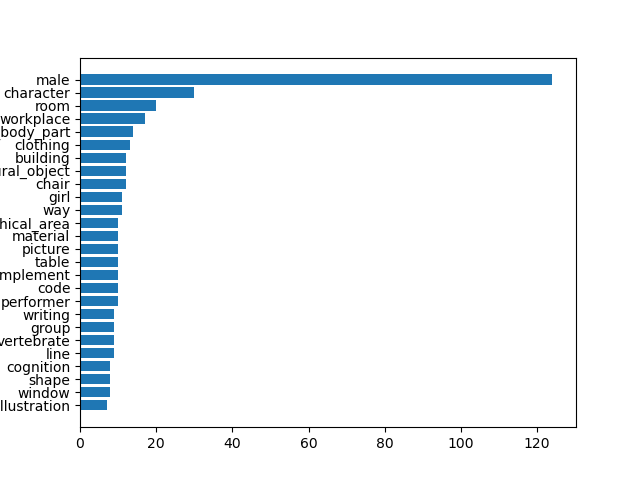

In [70]:
masks, data = load_data(1)
dh = DataHandler(masks, data)
count_dict = dh.get_label_names(counts=True)

df_c = pd.DataFrame(count_dict, index = ["counts"])
df_c = df_c.sort_values("counts", axis = 1)

plt.figure()
plt.barh(df_c.columns, df_c.loc["counts"])

Below is the wrapper class around logsitic regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from utils import DataHandler

class DreamLR:

    def __init__(self, masks, data, test_size=0.2):
        self.data_handler = DataHandler(masks, data, test_size=test_size)
        self.get_label_names = self.data_handler.get_label_names

    def run(self, feature_name, class_name = None, **kwargs):
        """
        Runs the model to predict "class_name" using "feature_name"

        Parameters:
            feature_name: one of the feature region names eg;
                ["FFA", "HVC", "LOC", "LVC", "PPA", "V1", "V2", "V3"]
            class_name: one of the names in self.label_names, if None, do multiclass
            **kwargs: any additional keyword arguments are passed to
                sklearn.linear_model.LogisticRegression
        
        Returns:
            model: the fitted model object
            testx: the features for the chosen feature group
            testy: the labels for the chosen class

        """
        print(f"running for class:{class_name}...")
        trainx = self.data_handler.get_feature(feature_name)
        testx = self.data_handler.get_feature(feature_name, split_set="test")
        
        model = LogisticRegression(
            solver="lbfgs", max_iter=1000, class_weight="balanced",**kwargs
        )

        trainy = self.data_handler.get_labels(label_name = class_name)
        testy = self.data_handler.get_labels(label_name = class_name, split_set="test")
        if class_name is None:
            model = MultiOutputClassifier(model)
        
        fit_model = model.fit(trainx, trainy)

        return fit_model, testx, testy

Below is the functions for plotting the confusion matrices.

In [26]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

def plot_cf(mcf, label_name, ax):
	sb.heatmap(mcf, annot=True, ax = ax, cbar = False, xticklabels = ["F", "T"], yticklabels=["F", "T"], cmap="Greens")
	ax.set_title(label_name)
	ax.set_xlabel("prediction")
	ax.set_ylabel("true label")

def plot_confusion_matrix(labels, predictions, label_names, **kwargs):
    """
    Plot and return the confusion matrices for a set of labels and predictions
    
    Parameters:
        labels: an array of the true labels, should have shape (n,) for single
            label classification or (n, n classes) for multilabel
        predictions: an array of the predictions from the features corresponding
            to the labels, should have the same shape as labels
        label_names: either the name of the class for single classification, or
            a list of class names with shape (n classes) for multilabel. Should
            be in the same order as the labels and predictions.
    """
    if labels.ndim == 2:
        nrow = np.sqrt(labels.shape[-1]).astype(int)
        fig, ax = plt.subplots(
            nrow + 1, nrow, 
            figsize = ((nrow + 1) *2, nrow*2)
        )
        ax = ax.flatten()
        ml_conf_matrix = multilabel_confusion_matrix(labels, predictions, **kwargs)
        for i in range(ml_conf_matrix.shape[0]):
            plot_cf(ml_conf_matrix[i], label_names[i], ax[i])
        fig.tight_layout()
        return fig
    else:
        fig, ax = plt.subplots(1)
        conf_matrix = confusion_matrix(labels, predictions, **kwargs)
        plot_cf(conf_matrix, label_names, ax)
        
        return fig

Brain Plots

In [ ]:
!pip install ipympl

In [27]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [28]:
def get_region(masks, data, feature_region, rand_jitter = None, sample_idx = 0):
    # get coordinates, mask, and corresponding data
    xyz = masks.loc[:, ["X", "Y", "Z"]]
    mask = masks.loc[:, feature_region].astype(bool)
    if sample_idx == "mean":
        fdata = np.array(data[:, mask].mean(0)).squeeze()
    else:
        fdata = np.array(data[sample_idx, mask]).squeeze()
    
    # get specified region, convert to array, and optionally jitter
    region = xyz.loc[mask]
    region_arr = region.to_numpy()
    if rand_jitter is not None:
        region_arr = region_arr + np.random.uniform(high=rand_jitter, size=3)
    
    # return tuple of region coordinates and data
    return region_arr.T, fdata

def brain_plot(region_data, region_names, figsize = (10, 10), axis="on", size_scalar = 1):
    nregions = len(region_data)
    colors = [plt.get_cmap("tab10")(i) for i in range(nregions)]
    
    fig = plt.figure(figsize=figsize)
    ax = Axes3D(fig, auto_add_to_figure = False)
    fig.add_axes(ax)
    
    for i in range(nregions):
        region, fdata = region_data[i]
        ax.scatter(
            *region, 
            s = fdata*size_scalar, 
            color = colors[i], 
            label = region_names[i], 
            marker = "s"
        )
    # legend setting hack from: https://stackoverflow.com/questions/24706125/setting-a-fixed-size-for-points-in-legend
    lgnd = ax.legend() 
    for i in range(nregions):
        lgnd.legendHandles[i]._sizes = [72.0]
    ax.axis(axis)

/home/emmaf/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


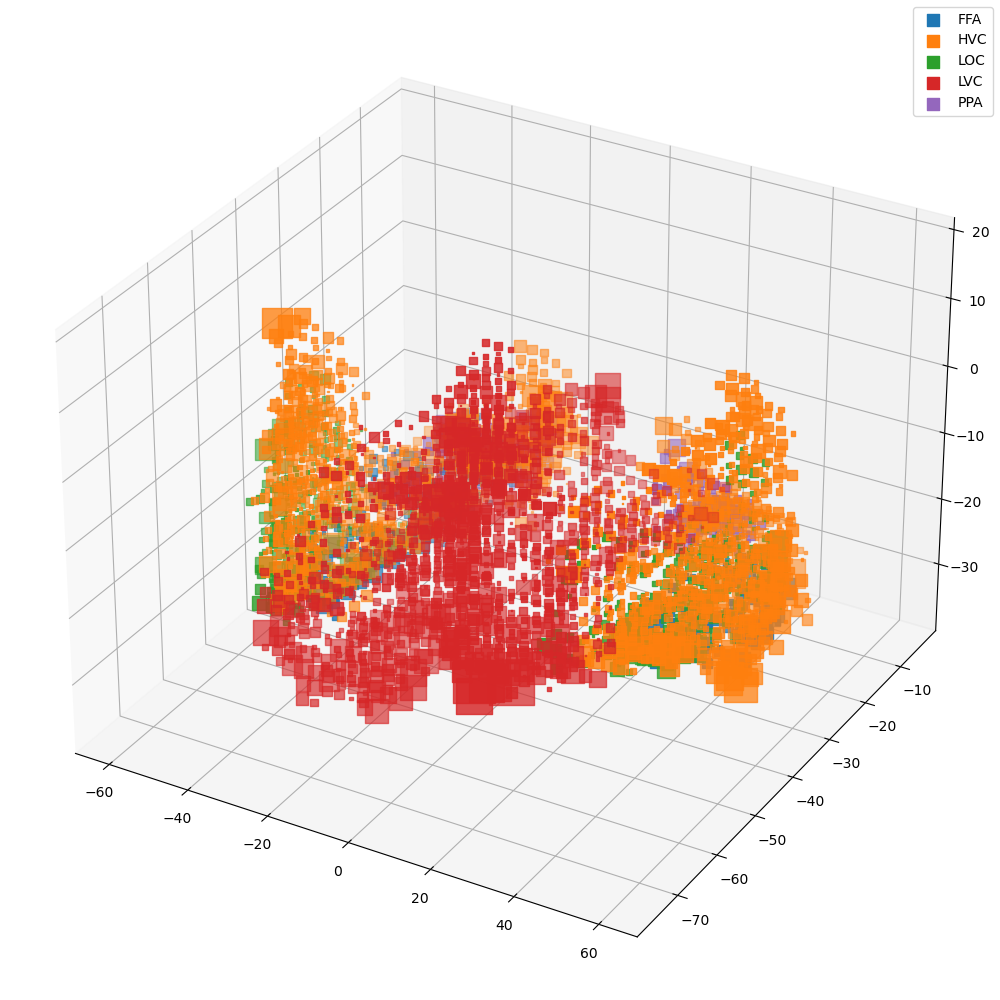

In [29]:
masks, data = load_data(3)

all_region_names = ["FFA", "HVC", "LOC", "LVC", "PPA"]
regions = [get_region(masks, data, region, rand_jitter=3, sample_idx = 1) for region in all_region_names]
brain_plot(regions, all_region_names, axis = "on", size_scalar=20)

# quick plotting helper
def quick_brain_plot(
    subject, # 1,2,or 3
    all_region_names = ["FFA", "HVC", "LOC", "LVC", "PPA"], # which regions to plot
    rand_jitter = 3, # how much to jitter points by (if None, don't jitter)
    sample_idx = 0, # index of the sample entry, if "mean", use the mean of all samples
    figsize = (10, 10), # figsize
    axis = "on", # "on" or "off" depending on whether to display the axis
    size_scalar=10 # a number to scale the size by
):
    masks, data = load_data(subject)

    regions = [get_region(masks, data, region, rand_jitter=rand_jitter, sample_idx = sample_idx) for region in all_region_names]
    brain_plot(regions, all_region_names, figsize = figsize, axis = axis, size_scalar=size_scalar)